CVAE mnist

In [0]:
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf

import keras
from keras.utils import np_utils
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


Load & process data.

In [0]:
# https://corochann.com/mnist-dataset-introduction-1138.html

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(y_train.shape)
print(y_train[301])

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(y_train.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_train.shape[1:])
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train[100][300:350])

(60000,)
7
(60000, 10)
(60000, 28, 28)
(28, 28)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.6156863  0.99215686 0.99215686 0.49019608 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.34901962 0.99215686
 0.98039216 0.22352941]


VLB

In [0]:
def vlb_bernoulli(x, x_decoded_mean, t_mean, t_log_var):
    '''    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) 
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of normal distribution q(t | x)
        t_log_var: (batch_size x latent_dim) log variance vector of normal distribution q(t | x)    
    '''
    # reconstruction loss
    # Binary cross-entropy which is commonly used for data like MNIST that can be modeled as Bernoulli trials.
    # https://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html
    # x is originally 0 to 255, after dividing by 255 we get float numbers ranging from 0 to 1
    loss = tf.reduce_sum(x * K.log(x_decoded_mean + 1e-10) + (1 - x) * K.log(1 - x_decoded_mean + 1e-10), axis=1)

    # KL divergence
    regularisation = 0.5 * tf.reduce_sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=1)

    vlb = tf.reduce_mean(loss + regularisation)

    return -vlb # return negative scalar value (tf.Tensor) of variational Lower Bound for minimization

Setup tf interactive session & connect it with keras.


In [0]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [0]:
batch_size = 1000
original_dim = 784 # Number of pixels
latent_dim = 64 # d, dimensionality of the latent code t.
hidden = 32 # Size of the hidden layer.
epochs = 30

x = Input(batch_shape=(batch_size, original_dim))

Encoder


In [0]:
def create_encoder(input_dim):
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(hidden, activation='relu'))
    encoder.add(Dense(hidden, activation='relu'))
    encoder.add(Dense(hidden, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder


encoder = create_encoder(original_dim)
h = encoder(x)

Output mean & log variance.

In [0]:
get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])

t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

Sampling from the distribution q(t | x) = N(t_mean, exp
(t_log_var)) with reparametrization trick.

In [0]:
def sampling(args):
    '''       
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the distribution
        args[1]: (batch_size x latent_dim) vector of log variance, diag of conv matrix of distribution
    '''
    t_mean, t_log_var = args

    e = K.random_normal(shape=(batch_size, latent_dim))
    samples = t_mean + K.exp(0.5 * t_log_var) * e # use t_log_sigma instead of t_log_var

    return samples # tf.Tensor of size (batch_size x latent_dim) from Gaussian distribution N(args[0], diag(args[1]))


t = Lambda(sampling)([t_mean, t_log_var])

Decoder

In [0]:
def create_decoder(input_dim):
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(hidden, activation='relu'))
    decoder.add(Dense(hidden, activation='relu'))
    decoder.add(Dense(hidden, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
    

decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

Setup the graph.

In [0]:
# One-hot labels placeholder.
label_dim = 10 # 0-9

x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, label_dim))

cvae_encoder = create_encoder(original_dim + label_dim)
h = cvae_encoder(concatenate([x, label], axis=1))

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])

cond_t_mean = get_t_mean(h) # Mean of the latent code (without label) for cvae model. (latent_dim)
cond_t_log_var = get_t_log_var(h) # Logarithm of the variance of the latent code (without label) for cvae model.

t = Lambda(sampling)([cond_t_mean, cond_t_log_var])

decoder = create_decoder(latent_dim + label_dim)
cond_x_decoded_mean = decoder(concatenate([t, label], axis=1)) # Final output of the cvae model.

Setup the model.

In [0]:
conditional_loss = vlb_bernoulli(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean)
cvae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: conditional_loss)

Train the model.

In [0]:
hist = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=2)




Train on 60000 samples, validate on 10000 samples
Epoch 1/30




 - 2s - loss: 289.6248 - val_loss: 212.1691
Epoch 2/30
 - 1s - loss: 205.6741 - val_loss: 200.8014
Epoch 3/30
 - 1s - loss: 199.2119 - val_loss: 197.2940
Epoch 4/30
 - 1s - loss: 196.2886 - val_loss: 194.0760
Epoch 5/30
 - 1s - loss: 191.1327 - val_loss: 186.9433
Epoch 6/30
 - 1s - loss: 185.9909 - val_loss: 183.6873
Epoch 7/30
 - 1s - loss: 183.0825 - val_loss: 181.1525
Epoch 8/30
 - 1s - loss: 180.0521 - val_loss: 177.8274
Epoch 9/30
 - 1s - loss: 176.2320 - val_loss: 173.2466
Epoch 10/30
 - 1s - loss: 171.8344 - val_loss: 168.3746
Epoch 11/30
 - 1s - loss: 167.5959 - val_loss: 165.4794
Epoch 12/30
 - 1s - loss: 164.7360 - val_loss: 162.2817
Epoch 13/30
 - 1s - loss: 162.6542 - val_loss: 161.2038
Epoch 14/30
 - 1s - loss: 160.9261 - val_loss: 158.7697
Epoch 15/30
 - 1s - loss: 159.1252 - val_loss: 157.3472
Epoch 16/30
 - 1s - loss: 157.5444 - val_loss: 157.2270
Epoch 17/30
 - 1s - loss: 155.6584 - val_loss: 153.7221


Plot mnist & generated output.

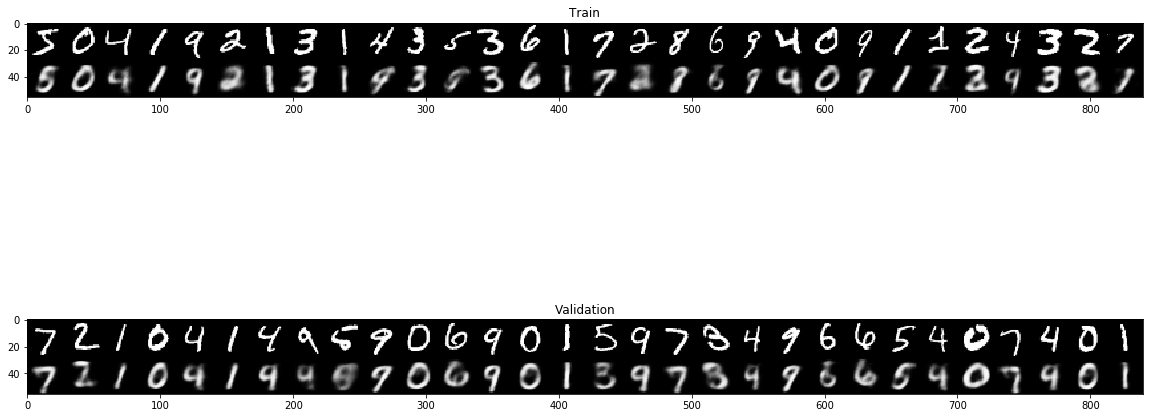

In [0]:
fig = plt.figure(figsize=(20, 10))

for fid_idx, (x_data, y_data, title) in enumerate(zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 30  # n digits
    digit_size = 28
    figure = np.zeros((digit_size * 2, digit_size * n)) # 2 rows, n cols

    # Generate new data
    decoded = sess.run(cond_x_decoded_mean, feed_dict={x: x_data[:batch_size, :], 
                                                       label: y_data[:batch_size, :]})
    
    for i in range(n):
        row_start = i * digit_size
        row_end = (i + 1) * digit_size
        col_end = digit_size

        # data
        figure[ :digit_size, i * digit_size: (i + 1) * digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        # decoded
        figure[digit_size: , i * digit_size: (i + 1) * digit_size] = decoded[i, :].reshape(digit_size, digit_size)

    ax = fig.add_subplot(2, 1, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)

plt.show()

Sample from the prior distribution  𝑝(𝑡)  (Gaussian) and then from the likelihood  𝑝(𝑥∣𝑡) .

In [21]:
# Prepare one hot labels of form
curr_labels = np.eye(10) # 10x10
print('curr_labels', curr_labels)
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.repeat(curr_labels, 10, axis=0)  # Its shape is 100 x 10.
print('curr_labels', curr_labels)

cond_label = tf.convert_to_tensor(curr_labels, dtype=np.float32)

def p_t_sampling(args):
  return K.random_normal(shape=(curr_labels.shape[0], latent_dim))

new_cond_t = Lambda(p_t_sampling)([])

cond_sampled_im_mean = decoder(concatenate([new_cond_t, cond_label], axis=1)) # tf.Tensor, 100 x 784

curr_labels [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
curr_labels [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0

Generate & plot new data.

(100, 784)


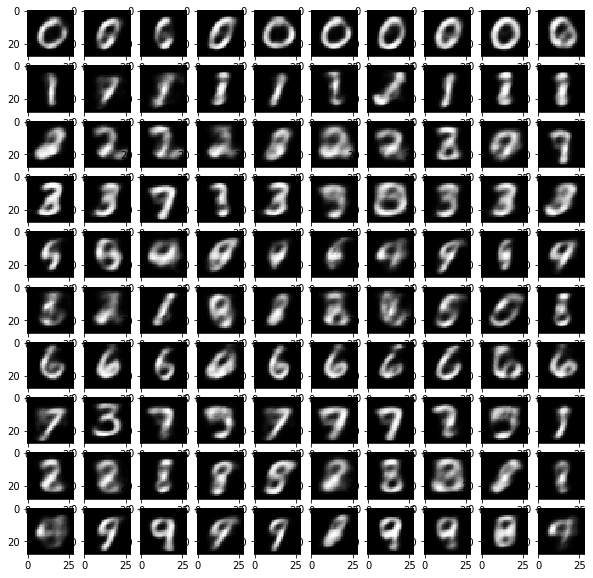

In [20]:
cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
print(cond_sampled_im_mean_np.shape)

# Show the sampled images.
plt.figure(figsize=(10, 10))

global_idx = 0
for digit in range(10):
    for _ in range(10):
      
        ax = plt.subplot(10, 10, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(28, 28), cmap='gray')
        global_idx += 1

plt.show()